In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import fbprophet
from fbprophet.plot import plot_plotly, plot_components_plotly

In [2]:
# load the zipcodes we are focusing on. It is formatted with column names as [zipcode, city, rank]
zipcodes = pd.read_csv('./zipcodes.csv')
# My dataset strips the leading 0 from zipcodes, which happens to be what the other dataset came as too. Since they both do this, the sets can still be compared without additional work (unlike R)
zipcodes['zipcode'] = zipcodes['zipcode'].astype(str)

#load the listing data
data = pd.read_csv('./downloads/RDC_Inventory_Core_Metrics_Zip_History.csv', header=0, parse_dates=True, low_memory=False)[:-2] # remove last two rows, which have shown themselvse as weird
data['year-month'] = pd.to_datetime(data['month_date_yyyymm'], format='%Y%m')

In [3]:
local_data = data[data['postal_code'].isin(zipcodes['zipcode'])]
local_listing_sum = local_data[['year-month', 'active_listing_count']].groupby(['year-month']).sum().reset_index().rename(columns = {'year-month': 'ds', 'active_listing_count': 'y'})

In [4]:
profile = pp.ProfileReport(local_data, 'mls profile report')

In [5]:
local_listing_sum.tail() # looks good

,ds,y
49,2020-08-01,176.0
50,2020-09-01,153.0
51,2020-10-01,175.0
52,2020-11-01,140.0
53,2020-12-01,112.0


In [6]:
m = fbprophet.Prophet()
# we have an inventory floor of 0, so let's establish that
local_listing_sum['floor'] = 0
m.fit(local_listing_sum)
# future does NOT predict, it simply makes timestamps into the future on a monthly frequency
future = m.make_future_dataframe(periods=12, freq = 'MS')

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [7]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
51,2020-10-01,300.526240,228.279010,366.294104
52,2020-11-01,217.267206,139.279595,291.328455
53,2020-12-01,143.083903,64.772530,214.659382
54,2021-01-01,95.757647,26.189931,173.670607
55,2021-02-01,54.522760,-17.704859,128.598391
56,2021-03-01,110.992549,36.082622,185.585457
57,2021-04-01,126.086436,47.795229,205.051269
58,2021-05-01,143.685602,70.600868,211.664117
59,2021-06-01,179.931263,105.081734,251.153065
60,2021-07-01,211.725896,142.116382,280.396478


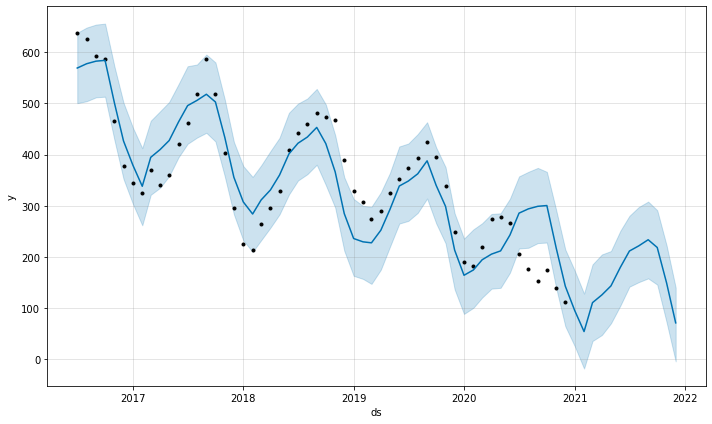

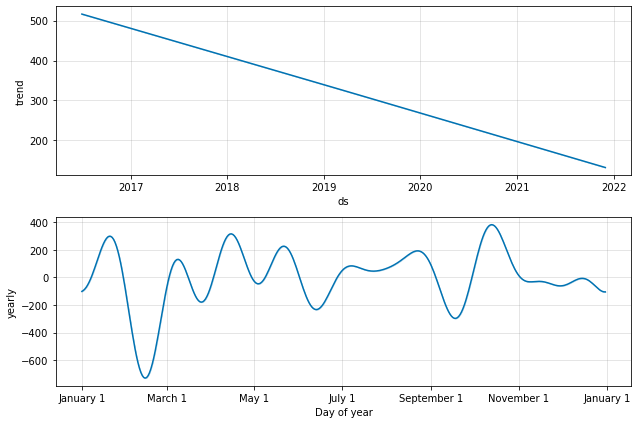

In [8]:
fig1 = m.plot(forecast)
decomp_plot = m.plot_components(forecast)